**Sentimental Analysis of Tweets**

In [25]:
import re
import pickle
import time
import numpy as np
import pandas as pd

import seaborn as sns
from wordcloud import WordCloud
import matplotlib.pyplot as plt

from nltk.stem import WordNetLemmatizer

from sklearn.model_selection import train_test_split

from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.svm import LinearSVC
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

The sentiment140 dataset is the one being used. 1,600,000 tweets that were taken from the Twitter API are included. The tweets can be used to identify sentiment because they have been marked (0 = Negative, 4 = Positive).

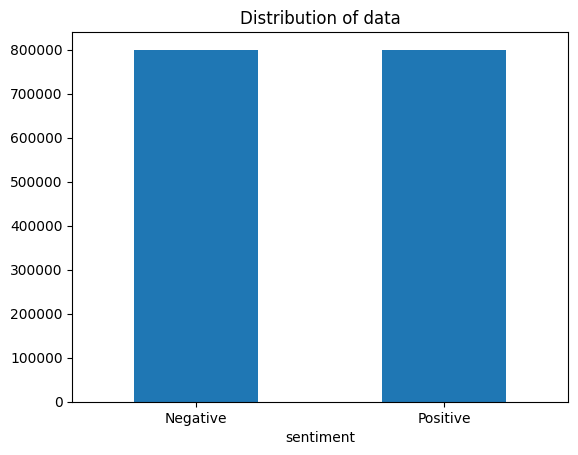

In [4]:
# Import dataset
DATASET_COLUMNS  = ["sentiment", "ids", "date", "flag", "user", "text"]
DATASET_ENCODING = "ISO-8859-1"
dataset = pd.read_csv('training.1600000.processed.noemoticon.csv',encoding=DATASET_ENCODING , names=DATASET_COLUMNS)

# Removing  unnecessary columns.
dataset = dataset[['sentiment','text']]

# Encode values of sentiment column
dataset['sentiment'] = dataset['sentiment'].replace(4,1)

# Plotting distribution for dataset.
ax = dataset.groupby('sentiment').count().plot(kind='bar', title='Distribution of data', legend=False)
ax.set_xticklabels(['Negative','Positive'], rotation=0)

# Storing data in lists.
text, sentiment = list(dataset['text']), list(dataset['sentiment'])

Define all emojis with their meanings.

In [5]:
emojis = {':)': 'smile', ':-)': 'smile', ';d': 'wink', ':-E': 'vampire', ':(': 'sad',
          ':-(': 'sad', ':-<': 'sad', ':P': 'raspberry', ':O': 'surprised',
          ':-@': 'shocked', ':@': 'shocked',':-$': 'confused', ':\\': 'annoyed',
          ':#': 'mute', ':X': 'mute', ':^)': 'smile', ':-&': 'confused', '$_$': 'greedy',
          '@@': 'eyeroll', ':-!': 'confused', ':-D': 'smile', ':-0': 'yell', 'O.o': 'confused',
          '<(-_-)>': 'robot', 'd[-_-]b': 'dj', ":'-)": 'sadsmile', ';)': 'wink',
          ';-)': 'wink', 'O:-)': 'angel','O*-)': 'angel','(:-D': 'gossip', '=^.^=': 'cat'}

Define all stopwords

In [6]:
stopwordlist = ['a', 'about', 'above', 'after', 'again', 'ain', 'all', 'am', 'an',
             'and','any','are', 'as', 'at', 'be', 'because', 'been', 'before',
             'being', 'below', 'between','both', 'by', 'can', 'd', 'did', 'do',
             'does', 'doing', 'down', 'during', 'each','few', 'for', 'from',
             'further', 'had', 'has', 'have', 'having', 'he', 'her', 'here',
             'hers', 'herself', 'him', 'himself', 'his', 'how', 'i', 'if', 'in',
             'into','is', 'it', 'its', 'itself', 'just', 'll', 'm', 'ma',
             'me', 'more', 'most','my', 'myself', 'now', 'o', 'of', 'on', 'once',
             'only', 'or', 'other', 'our', 'ours','ourselves', 'out', 'own', 're',
             's', 'same', 'she', "shes", 'should', "shouldve",'so', 'some', 'such',
             't', 'than', 'that', "thatll", 'the', 'their', 'theirs', 'them',
             'themselves', 'then', 'there', 'these', 'they', 'this', 'those',
             'through', 'to', 'too','under', 'until', 'up', 've', 'very', 'was',
             'we', 'were', 'what', 'when', 'where','which','while', 'who', 'whom',
             'why', 'will', 'with', 'won', 'y', 'you', "youd","youll", "youre",
             "youve", 'your', 'yours', 'yourself', 'yourselves']

Function to process the tweets

In [18]:
def preprocess(textdata):
    processedText = []

    # Create Lemmatizer and Stemmer
    wordLemm = WordNetLemmatizer()

    # Regex patterns
    urlPattern = r"((http://)[^ ]*|(https://)[^ ]*|( www\.)[^ ]*)"
    userPattern       = '@[^\s]+'
    alphaPattern      = "[^a-zA-Z0-9]"
    sequencePattern   = r"(.)\1\1+"
    seqReplacePattern = r"\1\1"

    for tweet in textdata:
        tweet = tweet.lower()

        tweet = re.sub(urlPattern,' URL',tweet) #Replace URL
        for emoji in emojis.keys():
            tweet = tweet.replace(emoji, "EMOJI" + emojis[emoji]) #Replace Emoji
        tweet = re.sub(userPattern,' USER', tweet) # Replace @USERNAME to 'USER'.
        tweet = re.sub(alphaPattern, " ", tweet) # Replace all non alphabets.
        tweet = re.sub(sequencePattern, seqReplacePattern, tweet) # Replace 3 or more consecutive letters by 2 letter.
        tweetwords = ''

        for word in tweet.split(): # Checking if the word is a stopword.
            if len(word)>1:
                word = wordLemm.lemmatize(word)
                tweetwords += (word+' ')
        processedText.append(tweetwords)

    return processedText

In [20]:
import nltk
nltk.download('wordnet')
nltk.download('omw-1.4')  # Optional, for better WordNet functionality

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

In [21]:
t = time.time()
processedtext = preprocess(text)
print(f'Text Preprocessing complete.')
print(f'Time Taken: {round(time.time()-t)} seconds')

Text Preprocessing complete.
Time Taken: 194 seconds


Word Cloud for Negative tweets

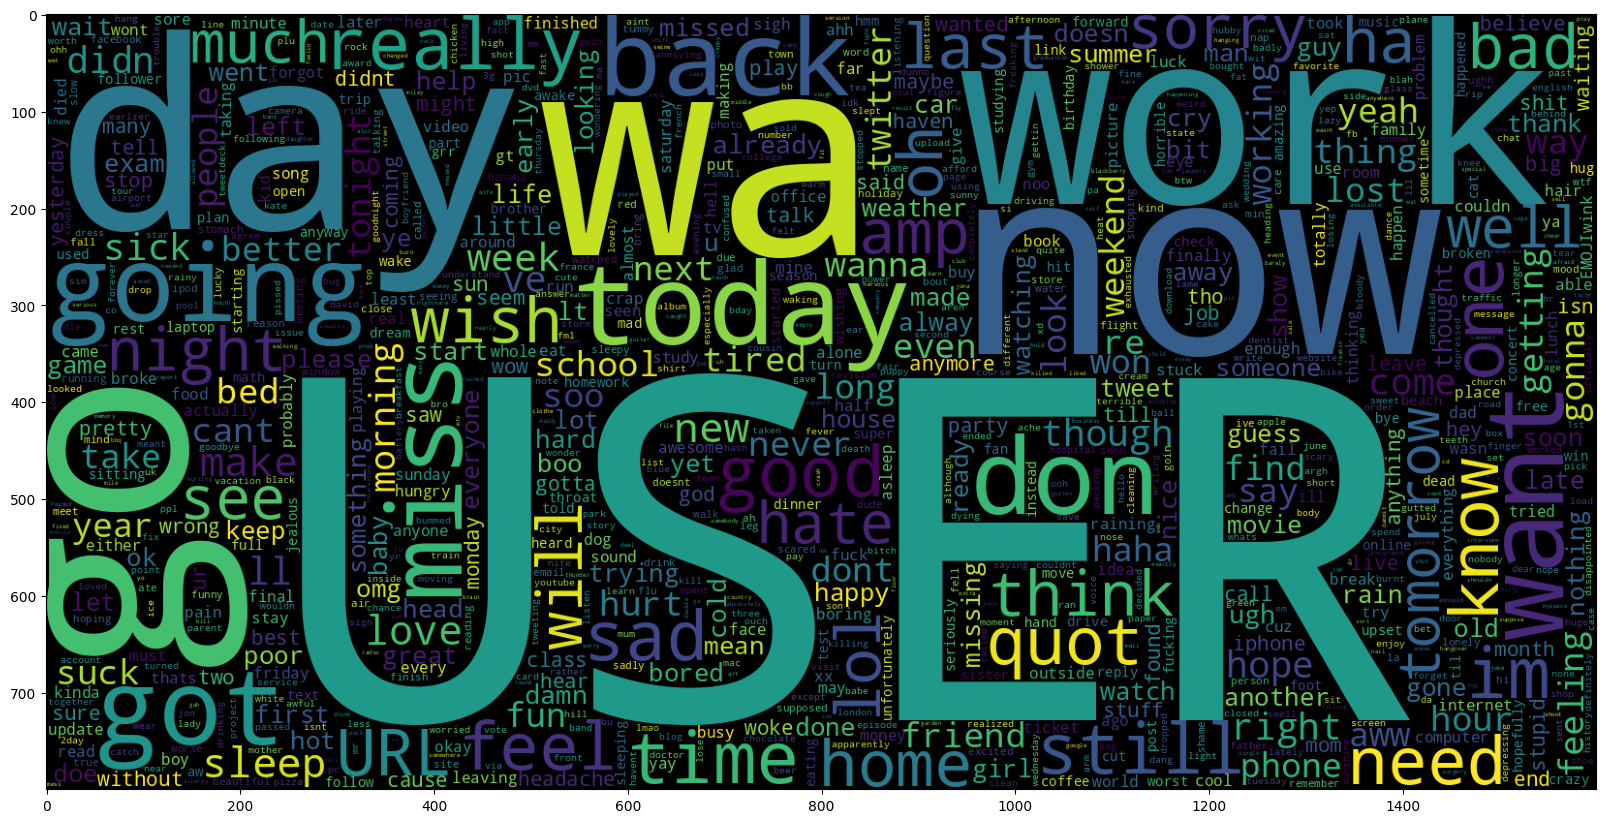

In [22]:
data_neg = processedtext[:800000]
plt.figure(figsize=(20,20))
wc = WordCloud(max_words = 1000, width = 1600, height = 800, collocations=False).generate(" ".join(data_neg))
plt.imshow(wc)

Word Cloud for Positive tweets

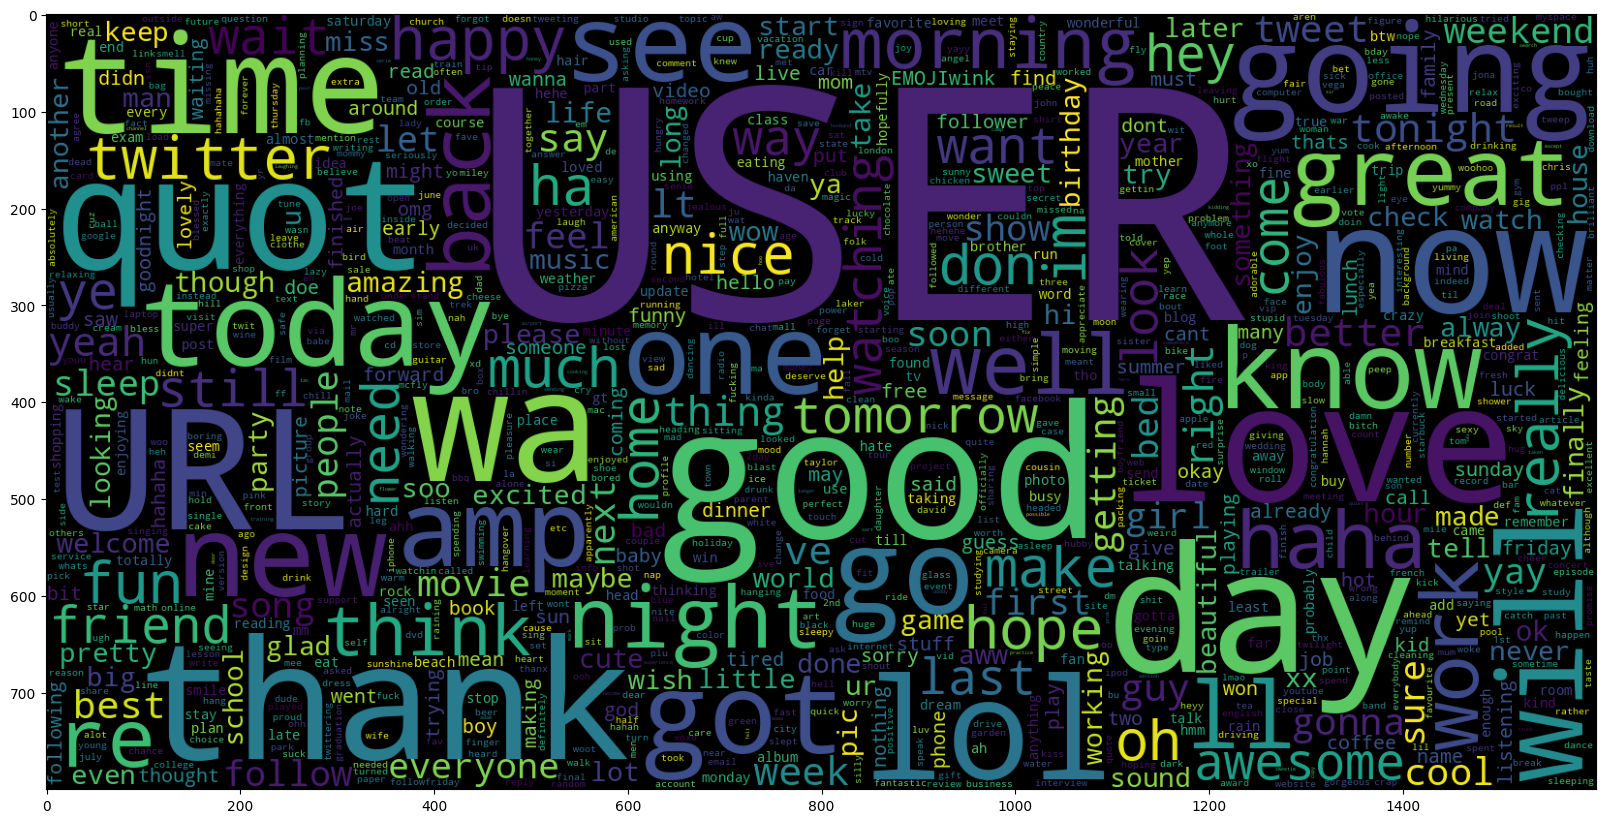

In [23]:
data_pos = processedtext[800000:]
wc = WordCloud(max_words = 1000 , width = 1600 , height = 800, collocations=False).generate(" ".join(data_pos))
plt.figure(figsize = (20,20))
plt.imshow(wc)

Split the data into train and test

In [26]:
X_train, X_test, y_train, y_test = train_test_split(processedtext, sentiment, test_size = 0.05, random_state = 0)
print(f'Data Split done.')

Data Split done.


Vectorize the dataset

In [28]:
vectorizer = TfidfVectorizer(ngram_range=(1,2), max_features=50000)
vectorizer.fit(X_train)
print(f'Vectorizer fitted')
print('No. of feature_words: ',len(vectorizer.get_feature_names_out()))

Vectorizer fitted
No. of feature_words:  50000


Transform the dataset

In [29]:
X_train = vectorizer.transform(X_train)
X_test = vectorizer.transform(X_test)
print(f'Data Transformed')

Data Transformed


Function to evaluate the model - displays confusion matrix

In [37]:
def model_evaluate(model):
    y_pred = model.predict(X_test)

    # classification report
    print(classification_report(y_test, y_pred))

    # confusion report
    cf_matrix = confusion_matrix(y_test, y_pred)

    categories = ['Negative', 'Positive']

    group_names = ['True Neg', 'False Pos','False Neg','True Pos']

    group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]

    labels = [f'{v1}\n{v2}' for v1, v2 in zip(group_names,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)

    sns.heatmap(cf_matrix, annot = labels, cmap = 'Blues',fmt = '',
                xticklabels = categories, yticklabels = categories)

    plt.xlabel("Predicted values", fontdict = {'size':14}, labelpad = 10)
    plt.ylabel("Actual values"   , fontdict = {'size':14}, labelpad = 10)
    plt.title ("Confusion Matrix", fontdict = {'size':18}, pad = 20)

BernoulliNB model

              precision    recall  f1-score   support

           0       0.80      0.78      0.79     39989
           1       0.79      0.80      0.79     40011

    accuracy                           0.79     80000
   macro avg       0.79      0.79      0.79     80000
weighted avg       0.79      0.79      0.79     80000



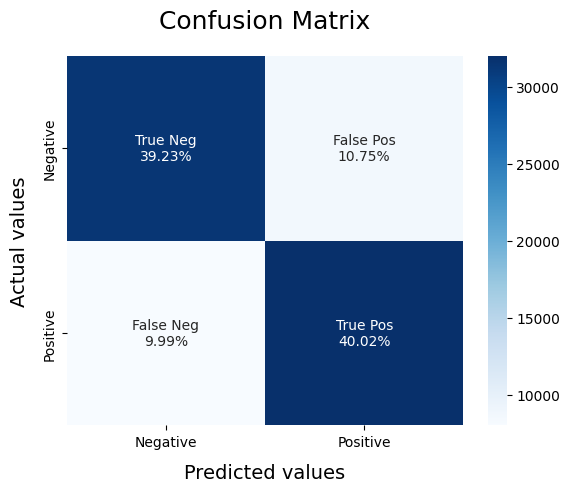

In [36]:
BNBmodel = BernoulliNB(alpha = 2)
BNBmodel.fit(X_train, y_train)
model_evaluate(BNBmodel)

Linear SVC Model

              precision    recall  f1-score   support

           0       0.83      0.81      0.82     39989
           1       0.81      0.83      0.82     40011

    accuracy                           0.82     80000
   macro avg       0.82      0.82      0.82     80000
weighted avg       0.82      0.82      0.82     80000



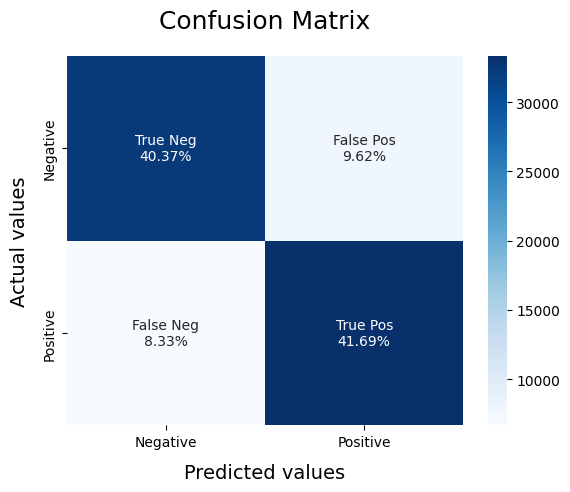

In [38]:
SVCmodel = LinearSVC()
SVCmodel.fit(X_train, y_train)
model_evaluate(SVCmodel)

Logistic Regression Model

              precision    recall  f1-score   support

           0       0.83      0.81      0.82     39989
           1       0.82      0.83      0.82     40011

    accuracy                           0.82     80000
   macro avg       0.82      0.82      0.82     80000
weighted avg       0.82      0.82      0.82     80000



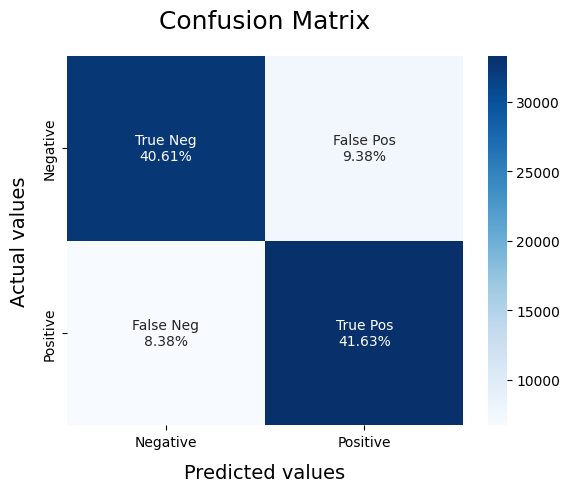

In [39]:
LRmodel = LogisticRegression(C =2, max_iter=1000, n_jobs=1)
LRmodel.fit(X_train, y_train)
model_evaluate(LRmodel)

Sample data to test upcoming tweets

In [42]:
def predict(vectoriser, model, text):
    # Predict the sentiment
    textdata = vectorizer.transform(preprocess(text))
    sentiment = model.predict(textdata)

    # Make a list of text with sentiment.
    data = []
    for text, pred in zip(text, sentiment):
        data.append((text,pred))

    # Convert the list into a Pandas DataFrame.
    df = pd.DataFrame(data, columns = ['text','sentiment'])
    df = df.replace([0,1], ["Negative","Positive"])
    return df

if __name__=="__main__":
    # Loading the models.
    #vectoriser, LRmodel = load_models()

    # Text to classify should be in a list.
    text = ["I hate our president",
            "I Love you.",
            "Yes! We can win."]

    df = predict(vectorizer, LRmodel, text)
    print(df.head())

                   text sentiment
0  I hate our president  Negative
1           I Love you.  Positive
2      Yes! We can win.  Positive
